# Model adaptive phase space reconstruction

In [1]:
%matplotlib notebook
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import schemes as sc
import dynamicalsystems as dyns

# Define parameters

In [2]:
class model_param:
    def __init__(self):
        self.method = sc.rk4   # Method of integration
        self.batch_time=30     # Time duration of training batch in terms of Δt steps
        self.batch_size=300    # Number of batches of training data
        self.lr = 1e-6         # Learning rate for model parameters
        self.lr_τ = 5e-4       # Leaning rate delay vector τ
        self.Nc = 200          # Maximum delay in terms of Δt steps
        self.niters=2000       # Maximum number of iterations
        self.test_freq=100      # Testing frequency in terms of iterations (for print and plot)
        self.viz=True          # Visualization
        self.savefig= True     # Set True to save figure
        self.folder='output'   # folder name to store output
        self.gpu=0             # GPU to be used (not yet implemented)

In [3]:
args = model_param()

# Define device

In [4]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')   # Remove once code is compatible with gpu 

# Folder to save output

In [5]:
try:
    os.mkdir(args.folder)
except:
    response = input("Warning: Folder alrady exist. Figures will be replaced. Do you want to replace? (y/n)")
    if response.lower()!='y':
        args.savefig= False

# Generate Time Series

In [6]:
t_true = torch.linspace(0, 100, 12001)
x_data = torch.tensor([1,1,0]).reshape(1,-1) # Initial Condition
param  = [10, 28, 8/3] # [σ, ρ, β]

dt  = t_true[1] - t_true[0]
fun = lambda t,x: dyns.Lorenz(x,param)
for i in range(1, len(t_true)):
    x_data = torch.cat([x_data, sc.rk4(fun, t_true, x_data[i-1,:], dt).reshape(1,-1)], 0)
    
fig = plt.figure()
axs = fig.add_subplot(1, 1, 1)
label = ['x','y','z']
[axs.plot(t_true, x_data[:,i], label = label[i]) for i in range(x_data.shape[1])]
axs.set_xlim([min(t_true), max(t_true)])
axs.set_xlabel('t')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

# Normalized time series

In [7]:
N_ts = 10000
t_true = t_true[0:N_ts]
x_data_sam   = x_data[-len(t_true):,:]

##################################
x_data = x_data_sam- x_data_sam.mean(0)
x_data = x_data/x_data.abs().max(0).values
##################################

fig = plt.figure()
axs = fig.add_subplot(1, 1, 1)

label = ['x','y','z']
[axs.plot(t_true, x_data[:,i], label = label[i]) for i in range(x_data.shape[1])]
axs.set_xlim([min(t_true), max(t_true)])
axs.set_xlabel('t')
plt.legend()
plt.show()

if x_data.shape[1]==3:
    fig = plt.figure()
    axs = fig.add_subplot(projection='3d')
    axs.plot(x_data[:,0], x_data[:,1], x_data[:,2])
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Observed data

In [8]:
x_true = x_data[:,0]
t_true = t_true

# Time step

In [9]:
dt = t_true[1] - t_true[0]

# Method to creates batch_size number of batches of true data of batch_time duration

In [10]:
def get_batch(t, x, Nc, τ, batch_time, batch_size):
    dt = t[1]-t[0]
    assert τ.max()<Nc*dt, "Maximum value of delay should be less than Nc*dt="+str(Nc*dt)+'.'
    z_true = sc.interp_linear(t, x, Nc, τ)
    id_sel = torch.randint(0, z_true.shape[0] - batch_time-1, (batch_size,))
    z_true_stack = torch.stack([z_true[id_sel + i, :] for i in range(batch_time)], dim=0)
    t_true_stack = torch.stack([t_true[id_sel + i] for i in range(batch_time)], dim=0)
    return t_true_stack.to(device), z_true_stack.to(device)

# Integrate the <i>fun</i> from initial state $z_0$ for given time array $t$

In [11]:
def get_pred(fun, z0, t):
    dt = len(t)
    z_pred = z0
    for i in range(1, len(t)):
        z_next = args.method(fun, t[i], z_pred[i - 1, :, :], dt)
        z_pred = torch.cat([z_pred, z_next.reshape(1, z_pred.shape[1], z_pred.shape[2])], 0)
    return z_pred

# Define neural ODE

In [12]:
class ODEFunc(nn.Module):
    
    def __init__(self, n):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n, n+100),
            nn.Tanh(),
            nn.Linear(n+100, n),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.001)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

# Function to modify delay vector and return modified ODE function 

In [13]:
def get_fun(func, optimizer, optimizer_τ, lr, lr_τ, τ, acc):
    l_0 = len(τ)
    τ = sc.merge(τ, acc)
    
    if l_0>len(τ):
        print('Merged τ:',τ)
        func = ODEFunc(n=len(τ)).to(device)
        
    τ = torch.tensor(τ.detach().numpy(), device=device, requires_grad=True)
    optimizer = optim.RMSprop(func.parameters(), lr=lr)   # lr=1e-4
    optimizer_τ = optim.RMSprop([τ], lr=lr_τ)             # lr=1e-6 => Gives ok results
    
    return func, optimizer, optimizer_τ, τ

In [14]:
def plot_cmp(fig, title, kk, tt,zt, tp,zp):
    plt.clf()
    axs_arr = [fig.add_subplot(zt.shape[2]-1,1,i+1) for i in range(zt.shape[2]-1)] 
    for p_id in range(args.batch_size):
        for i in range(zt.shape[2]-1):
            axs_arr[i].plot(zt[:, p_id, 0].detach().numpy(), zt[:, p_id, i+1].detach().numpy(),'k-')
            axs_arr[i].plot(zp[:, p_id, 0].detach().numpy(), zp[:, p_id, i+1].detach().numpy(),'r--', linewidth=2)
            axs_arr[i].set_title(title)
            axs_arr[i].set_xlabel('x(t)',fontsize=20)
            axs_arr[i].set_ylabel('x(t+$\\tau_'+str(i+1)+'$)',fontsize=20)
            plt.tight_layout()
        
    plt.show(block=False)
    fig.canvas.draw()
    
    if args.savefig:
        fig_name = args.folder+'/'+str(kk)+'.png'
        print('Saving figure:', fig_name)
        plt.savefig(fig_name)
    plt.pause(0.001)

# Initialize delay vector $\tau$ and $acc$. If $|\tau_i-\tau_j|<acc$ then $\tau_i$ and $\tau_j$ will merge

In [15]:
τ = torch.tensor((torch.linspace(0,60,5)*dt).detach().numpy(), device=device, dtype=torch.float, requires_grad=True)
acc = 0.5*dt

# Initialize function and optimizer

In [16]:
func = ODEFunc(n=len(τ)).to(device)
optimizer = optim.RMSprop(func.parameters(), lr=args.lr)
optimizer_τ = optim.RMSprop([τ], lr=args.lr_τ)

# Main function

<IPython.core.display.Javascript object>


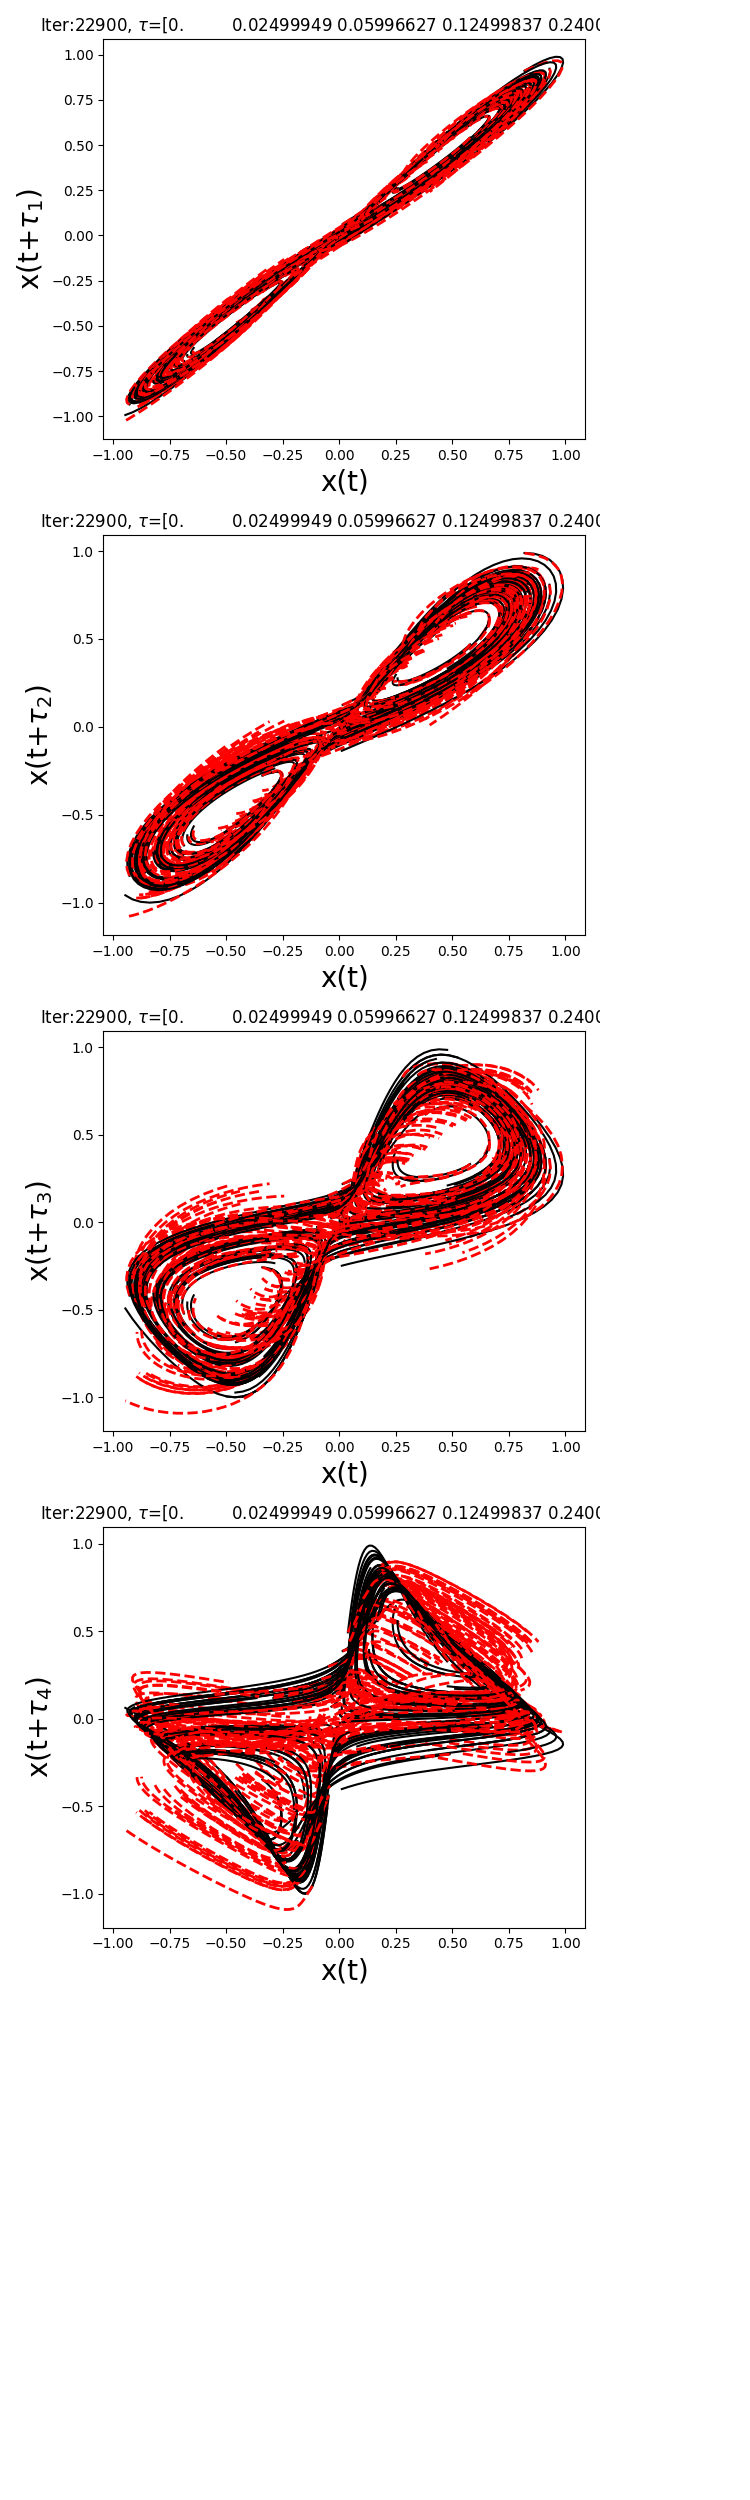

Iter: 0
τ: tensor([0.0000, 0.1250, 0.2500, 0.3750, 0.5000], requires_grad=True)
Saving figure: output/0.png
Iter: 100
τ: tensor([0.0000, 0.1250, 0.2500, 0.3750, 0.5000], requires_grad=True)
Saving figure: output/100.png
Iter: 200
τ: tensor([0.0000, 0.1250, 0.2500, 0.3750, 0.5000], requires_grad=True)
Saving figure: output/200.png
Iter: 300
τ: tensor([0.0000, 0.1250, 0.2500, 0.3750, 0.5000], requires_grad=True)
Saving figure: output/300.png
Iter: 400
τ: tensor([0.0000, 0.0850, 0.1700, 0.2250, 0.3700], requires_grad=True)
Saving figure: output/400.png
Iter: 500
τ: tensor([0.0000, 0.0550, 0.1500, 0.1650, 0.3200], requires_grad=True)
Saving figure: output/500.png
Iter: 600
τ: tensor([0.0000, 0.0350, 0.1200, 0.1450, 0.2900], requires_grad=True)
Saving figure: output/600.png
Iter: 700
τ: tensor([0.0000, 0.0250, 0.1100, 0.1350, 0.2800], requires_grad=True)
Saving figure: output/700.png
Iter: 800
τ: tensor([0.0000, 0.0250, 0.1000, 0.1250, 0.2600], requires_grad=True)
Saving figure: output/800.

Saving figure: output/7200.png
Iter: 7300
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/7300.png
Iter: 7400
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/7400.png
Iter: 7500
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/7500.png
Iter: 7600
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/7600.png
Iter: 7700
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/7700.png
Iter: 7800
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/7800.png
Iter: 7900
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/7900.png
Iter: 8000
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/8000.png
Iter: 8100
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2

Iter: 14400
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/14400.png
Iter: 14500
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/14500.png
Iter: 14600
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/14600.png
Iter: 14700
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/14700.png
Iter: 14800
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/14800.png
Iter: 14900
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/14900.png
Iter: 15000
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/15000.png
Iter: 15100
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/15100.png
Iter: 15200
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires

Saving figure: output/21400.png
Iter: 21500
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/21500.png
Iter: 21600
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/21600.png
Iter: 21700
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/21700.png
Iter: 21800
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/21800.png
Iter: 21900
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/21900.png
Iter: 22000
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/22000.png
Iter: 22100
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/22100.png
Iter: 22200
τ: tensor([0.0000, 0.0250, 0.0600, 0.1250, 0.2400], requires_grad=True)
Saving figure: output/22200.png
Iter: 22300
τ: tensor([0.0000, 0.0250, 0

In [ ]:
fig = plt.figure(figsize=[6,20])

for kk in range(100000):
    func, optimizer, optimizer_τ, τ = get_fun(func, optimizer, optimizer_τ, args.lr, args.lr_τ, τ, acc)
    
    optimizer.zero_grad()
    optimizer_τ.zero_grad()
    
    t_batch, z_batch = get_batch(t_true, x_true, args.Nc, τ, args.batch_time, args.batch_size)
    z_pred = get_pred(func, z_batch[0,:,:].reshape(1, z_batch.shape[1], z_batch.shape[2]), t_batch[:,0])
    loss = torch.mean(torch.abs(z_pred - z_batch))
    loss.backward()
    optimizer.step()
    
    if kk>300:
        optimizer_τ.step()
        with torch.no_grad():
            τ[0] = 0.0
        
    if kk%args.test_freq==0:
        print('Iter:',kk)
        print('τ:',τ)
        plot_cmp(fig, 'Iter:'+ str(kk)+', '+'$\\tau$='+str(τ.detach().numpy()), kk, t_batch, z_batch, t_batch, z_pred)
    